$\mathbf{\text{Foundations of Deep Learning:  Assignment 2}}$ \\

**Team:** \
B00798800 - Arindam Roy \
B00804388 - Pallav SAHU 

# Importing Useful Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable


from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q torcheval
from torcheval.metrics.functional import multiclass_f1_score

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.3 MB/s eta 0:00:00


In [2]:
torch.cuda.is_available()

True

In [3]:
device

device(type='cuda')

In [4]:
# mounting drive to access files
from google.colab import drive

drive = drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# create a directory for saving the models and the training progress
save_folder = 'drive/MyDrive/FDL/FDL_project2/model_try10_gpu_deepfvn'

In [6]:
##function which saves the overall accuracy and average loss at the end of each epoch,
##both for the training and the validation set
def write_results(save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    with open('./{}/progress.txt'.format(save_folder),'a') as ff:
      ff.write(' E: ')
      ff.write(str(epoch))
      ff.write('         ')
      ff.write(' TRAIN_OA: ')
      ff.write(str('%.3f' % train_acc))
      ff.write(' VAL_OA: ')
      ff.write(str('%.3f' % val_acc))
      ff.write('         ')
      ff.write(' TRAIN_IOU_LOSS: ')
      ff.write(str('%.3f' % train_loss))
      ff.write(' VAL_IOU_LOSS: ')
      ff.write(str('%.3f' % val_loss))
      ff.write('\n')

#Importing images + mask & Preprocessing


In [ ]:
! mkdir Hurricane_Harvey
! mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors
! gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/
! gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

In [7]:
# Defining the path variables for the image rasters and segmentation masks

IMAGE_PATH = '/content/drive/MyDrive/Hurricane_Harvey/rasters/raw/'
MASK_PATH = '/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/'

In [8]:
# n_classes = 27 as [0,26] labels

'''
Here we created a function "create_df" which outputs the indices of the training and testing images + mask based on the
availability of the mask in the imported dataset
'''

def create_df():
    train_set = []
    for dirname, _, filenames in os.walk(MASK_PATH):
      for filename in filenames:
          train_set.append(filename.split('.')[0])
    # print(train_set)
    name = []
    name_test_final = []
    
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
          if filename.split('.')[0] in train_set:
            name.append(filename.split('.')[0])
          else:
             name_test_final.append(filename.split('.')[0])
            # print(filename.split('.')[0])
    
    return (pd.DataFrame({'id': name}, index = np.arange(0, len(name))),\
            pd.DataFrame({'id': name_test_final}, index = np.arange(0, len(name_test_final))))



In [9]:
# Verifying that number of overall training images are 299 as mentioned on the challenge description
df = create_df()[0]
print('Total Images: ', len(df))

Total Images:  299


In [10]:
# Defining test and train index dataframes
train_df = create_df()[0]
test_df = create_df()[1]
print('Total train Images: ', len(train_df))
print('Total test Images: ', len(test_df))

Total train Images:  299
Total test Images:  75


In [11]:
#split overall train data into further train(90%) and validation (10%) sets to overcome and keep a check on overfitting 
# keeping in mind the possible output classes in the training masks, threshold kept


tr_sel = []
val_sel = []

for i in range(train_df.shape[0]):
  masksss = cv2.imread(MASK_PATH + df['id'][i] + '.png', cv2.IMREAD_GRAYSCALE)
  if len(np.unique(masksss)) > 8 :
    tr_sel.append( df['id'][i])
  else :
    val_sel.append( df['id'][i])

In [12]:
print(len(tr_sel), len(val_sel))

222 77


In [14]:
X_tr1, X_val1  = train_test_split(tr_sel, test_size=0.1, random_state=7)
X_tr2, X_val2  = train_test_split(val_sel, test_size=0.1, random_state=7)

In [15]:
tr_new = X_tr1 + X_tr2
tr_new = np.array(tr_new, dtype = 'object')

val_new = X_val1 + X_val2
val_new = np.array(val_new,  dtype = 'object')

In [17]:
print(len(tr_new),len(val_new))

268 31


In [19]:
# creating train and validation sets
X_train, X_val = tr_new, val_new

In [20]:
print(X_train.shape, X_val.shape)

(268,) (31,)


# Verfiying and Visualizing imported images + masks

In [21]:
# taking an image and visualizing the shape of its resolution which is very high 
imagesss = cv2.imread(IMAGE_PATH + df['id'][50] + '.tif')
imagesss.shape

(3000, 4000, 3)

In [22]:
# taking a mask and visualizing the shape of its resolution which is very high
masksss = cv2.imread(MASK_PATH + df['id'][50] + '.png', cv2.IMREAD_GRAYSCALE)
masksss.shape

(3000, 4000)

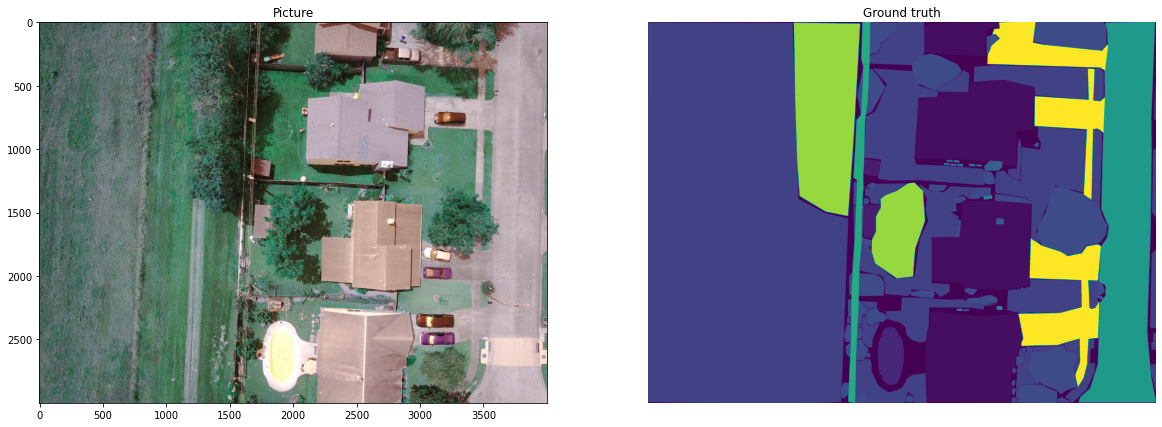

In [23]:
# taking an image and the corresponding mask to visualizing the data side-by-side

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(imagesss)
ax1.set_title('Picture');

ax2.imshow(masksss)
ax2.set_title('Ground truth')
ax2.set_axis_off()

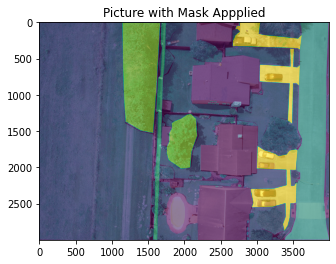

In [24]:
# taking an image and the corresponding mask to visualizing the data stacked over each other

plt.imshow(imagesss)
plt.imshow(masksss, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

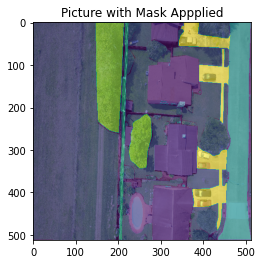

In [25]:
# Trying out the resizing of the image before creating class definitions

img = cv2.imread(IMAGE_PATH + df['id'][50] + '.tif')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASK_PATH + df['id'][50] + '.png', cv2.IMREAD_GRAYSCALE)

# Crop the center of the image
img = np.asarray(img)
mask = np.asarray(mask)

# Define the target size for image and mask
target_height = 512
target_width = 512
target_width_mask = 512

target_size = (target_height, target_width)
target_size_mask = (target_height, target_width_mask)

# Resize the image
'''
For 'RGB IMAGE' we have used "interpolation = cv2.INTER_LINEAR_EXACT" which uses the bilinear interpolation algorithm. 
This does the interpolation in two dimensions and predicts the function used to calculate the color of a pixel.
This algorithm is effective in handling visual distortions while zooming or enlarging an image.

For 'GRAYSCALE MASKS' we have used "interpolation = cv2.INTER_NEAREST_EXACT" which uses the nearest neighbor interpolation algorithm.
It retains the sharpness of the edges though the overall image may be blurred.

'''
img = cv2.resize(img, target_size, interpolation = cv2.INTER_LINEAR_EXACT) 
mask = cv2.resize(mask, target_size_mask, interpolation = cv2.INTER_NEAREST_EXACT)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Creating Dataloaders and CNN compatible classes

## Normalization of images 
Trying to find a mean and standard deviaion of train images for normalizing across the RGB channels

In [ ]:
# class loadImg(Dataset):
    
#     def __init__(self, img_path, mask_path, X):
#         self.img_path = img_path
#         self.mask_path = mask_path
#         self.X = X
        
#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, idx):
#         img = cv2.imread(self.img_path + self.X[idx] + '.tif')
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
#         img = Image.fromarray(img)
#         t = T.Compose([T.ToTensor()])
#         img = t(img)

#         mask = torch.from_numpy(mask).long()

#         return img, mask

In [ ]:
# train_set = loadImg(IMAGE_PATH, MASK_PATH, X_train)

In [ ]:
# # Compute the mean and std of the dataset, which is roughly consistent for training images

# mean = torch.zeros(3)
# std = torch.zeros(3)

# for image, label in train_set:
#     for i in range(3):
#         mean[i] += image[i,:,:].mean()
#         std[i] += image[i,:,:].std()

# mean /= len(train_set)
# std /= len(train_set)

# print(f"Mean values: {mean}")
# print(f"Standard deviation values: {std}")

In [21]:
# storing values for future use

mean_store = [0.4416, 0.4683, 0.3926]
std_store = [0.1777, 0.1602, 0.1885]

## Balancing the Un-balanced Dataset 
Trying to find the weights to be applied to the loss criterion parameter "weights" so as to adjust for class imbalance present in the images and masks

In [ ]:
# run carefully, takes around 20-30 minutes to run

# Weight calculation for classes

# Create an empty dictionary to store the class counts
# class_counts = {i: 0 for i in range(27)}

# # Iterate over the dataset to count the number of occurrences of each class
# for _, mask in train_set:
#     # convert mask tensor to numpy array
#     mask = mask.numpy()
#     # Flatten the mask to 1D array
#     mask = mask.ravel()
#     # convert to tensor
#     mask = torch.from_numpy(mask)
#     # use torch.unique() to count the number of occurrences of each class
#     class_id, class_counts_val = torch.unique(mask, return_counts=True)

#     # print(class_id,class_counts_val)

#     # store the result in the dictionary
#     for i in range(len(class_id)):
#         class_counts[int(class_id[i])] += int(class_counts_val[i])

# print(class_counts)

{0: 270291342, 1: 301769953, 2: 7617711, 3: 12718304, 4: 4913813, 5: 850145540, 6: 355094985, 7: 380403, 8: 1862821, 9: 131350, 10: 1102058, 11: 39107, 12: 431726, 13: 785933, 14: 125930910, 15: 3549129, 16: 25713353, 17: 326484, 18: 601397, 19: 30265762, 20: 1193530, 21: 3257370, 22: 192485515, 23: 127304418, 24: 494962228, 25: 27667, 26: 45281383}


In [ ]:
# # calculate the total number of pixels in the masks
# total_pixels = sum(class_counts.values())

# # calculate the weight for each class and cap at 

# weights = {class_id: ((total_pixels - count) / total_pixels) for class_id, count in class_counts.items()}
# # weights = {class_id: round(1/(count / total_pixels),4) for class_id, count in class_counts.items()}


# print(weights)

# # Create a weight tensor
# weights_tsr = torch.Tensor([weights[i] for i in range(27)])


# # normalizing the weight tensor
# # weights_tsr = torch.nn.functional.normalize(weights_tsr, p=-1)
# weights_tsr = weights_tsr / weights_tsr.sum()

# # checking for value of sum of weight tsr
# print(weights_tsr.sum())
# print(weights_tsr)

{0: 0.9054324970530101, 1: 0.8944189972624409, 2: 0.9973347725379904, 3: 0.9955502154005336, 4: 0.9982807920449096, 5: 0.7025574690464176, 6: 0.8757620359129046, 7: 0.9998669074578662, 8: 0.9993482501914278, 9: 0.9999540442493637, 10: 0.9996144202311787, 11: 0.999986317536809, 12: 0.9998489509524234, 13: 0.9997250236698532, 14: 0.9559402398374192, 15: 0.9987582574244397, 16: 0.9910036053407716, 17: 0.9998857722322747, 18: 0.9997895877383678, 19: 0.9894108427005113, 20: 0.9995824166954178, 21: 0.9988603358701943, 22: 0.932654614933928, 23: 0.9554596871830995, 24: 0.8268263363203151, 25: 0.999990320078014, 26: 0.9841572900981184}
tensor(1.0000)
tensor([0.0348, 0.0344, 0.0384, 0.0383, 0.0384, 0.0270, 0.0337, 0.0385, 0.0384,
        0.0385, 0.0384, 0.0385, 0.0385, 0.0385, 0.0368, 0.0384, 0.0381, 0.0385,
        0.0385, 0.0381, 0.0384, 0.0384, 0.0359, 0.0367, 0.0318, 0.0385, 0.0379])


In [22]:
# Storing the weight tensor for future use, which is roughly consistent for training images
weights_tsr = torch.tensor([0.0348, 0.0344, 0.0384, 0.0383, 0.0384, 0.0270, 0.0337, 0.0385, 0.0384,
        0.0385, 0.0384, 0.0385, 0.0385, 0.0385, 0.0368, 0.0384, 0.0381, 0.0385,
        0.0385, 0.0381, 0.0384, 0.0384, 0.0359, 0.0367, 0.0318, 0.0385, 0.0379])

# Neural Network Model Architecture (WIP)
As the task is to input an RGB image (3 channels x W x H ) and predict a semantic segmentation mask for the 26 classes + 1 background class, we have leveraged various "pre-trained encoder-decoder architectures", which at an overall level, first learn the features by convolution and then bring back the features to required segmented polygons as the logits and the number of output class labels using up-convolution/ transpose-convolution

In [23]:
# trying to use suggested preprocessing for the inputs fed into a particular backbone
from segmentation_models_pytorch.encoders import get_preprocessing_fn
preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')

In [24]:
model = smp.DeepLabV3Plus(encoder_name='resnet101', encoder_weights='imagenet', classes=27, activation=None)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:

# model = smp.FPN('resnet152', encoder_weights='imagenet', encoder_depth=5, classes=27, decoder_segmentation_channels=256,activation=None)

In [ ]:

# model = smp.Unet('resnet101', encoder_weights='imagenet', classes=27, decoder_use_batchnorm =True, 
#                  activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
#                  )

In [ ]:

# model = smp.PSPNet(encoder_name='resnet152', encoder_weights='imagenet', classes=27, activation=None)

In [ ]:
# printing model layers
model

# Creating Dataloaders and Model architecture compatible classes

## Dataloader class description

The provided code defines a custom dataset class called DroneDataset that inherits from the PyTorch Dataset class. This class is used to load, preprocess, and return images and masks for training and testing a model.


---


The __init__ method of the class takes several arguments:

1. img_path: a string representing the path to the directory containing the images.

2. mask_path: a string representing the path to the directory containing the masks.

3. X: a list of strings representing the indices of the images (without the file extension).

4. mean: a tuple representing the mean values of the image channels.

5. std: a tuple representing the standard deviation values of the image channels.

6. transform: a transform object from albumentations library to apply data 
augmentation.

7. patch: a boolean flag indicating whether the images should be divided into patches.



---


The __len__ method returns the length of the dataset, which is the number of images.


---


The __getitem__ method takes an index, idx, as an input and returns the idx-th image and its corresponding mask. The method reads the image and mask from the specified paths, converts it from BGR to RGB, resizes the image and mask to a fixed size of 512x512 while preserving the aspect ratio. Then it applies the data augmentation using the albumentations library if the transform is not None. After that, it applies normalization to the image using the provided mean and standard deviation, and converts the image to a PyTorch tensor. The mask is converted to a PyTorch tensor of type long.


---



The __tiles__ method is used to divide the image and mask into smaller patches of size 512x512. It uses the PyTorch's unfold method to divide the image and mask into overlapping patches of the desired size. Then it reshapes the patches to have the desired dimensions.


In [25]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        img = np.asarray(img)
        mask = np.asarray(mask)

        # Define the target size
        target_height = 512
        target_width = 512
        target_width_mask = 512

        target_size = (target_height, target_width)
        target_size_mask = (target_height, target_width_mask)

        # Resize the image
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_LINEAR_EXACT)
        mask = cv2.resize(mask, target_size_mask, interpolation = cv2.INTER_NEAREST_EXACT)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)

        mask = torch.from_numpy(mask).long()

        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
       
        # change n_s1 as you change the image shape dimensions
        n_sq = 512
        # aspect_ratio = img.shape[1]/img.shape[0]
        aspect_ratio = 1

        img_patches = img.unfold(1, n_sq, n_sq).unfold(2, (n_sq/aspect_ratio), (n_sq/aspect_ratio)) 
        img_patches  = img_patches.contiguous().view(3,-1, (n_sq/aspect_ratio), (n_sq/aspect_ratio)) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, n_sq, n_sq).unfold(1, (n_sq/aspect_ratio), (n_sq/aspect_ratio))
        mask_patches = mask_patches.contiguous().view(-1, (n_sq/aspect_ratio), (n_sq/aspect_ratio))
        
        return img_patches, mask_patches

In [26]:
# defining the input parameters for the DroneDataset

'''
RGB mean and std values calculated as before
'''
mean = [0.4416, 0.4683, 0.3926]
std = [0.1777, 0.1602, 0.1885]


'''
Transforms for train and validation images using "albumentations" module
'''
t_train = A.Compose([
                   A.OneOf(
                     [A.HorizontalFlip(), A.VerticalFlip(),  A.RandomBrightnessContrast((0,0.5),(0,0.5))],p=0.75,
                     )
                   ])

t_val = A.Compose([
                   A.OneOf(
                     [A.HorizontalFlip(), A.VerticalFlip(),  A.RandomBrightnessContrast((0,0.5),(0,0.5))],p=0.75,
                     )
                   ])


'''
Calling the "DroneDataset" class with desired inputs
'''
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, transform=t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, transform=t_val, patch=False)


'''
Calling the Dataloader with desired batch sizes for training and validation
'''

batch_size= 10
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

batch_size= 4
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model Training

## Defining evaluation metrics

1. pixel_accuracy : to track per-pixel accuracy for each output label and averaged across classes to generate a single value

2. mIoU : to track Dice-coefficient or similarity of predicition set with the a specific mask label for each class and averaged across classes to generate a single value


In [27]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [28]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=27):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = 2*(intersect + smooth) / (union + intersect +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Defining Model training routine and Learning rate scheduler

In [29]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)

    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device);
            mask = mask_tiles.to(device);

            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            optimizer.zero_grad() #reset gradient

            #backward
            loss.backward()
            optimizer.step() #update weight          
            
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()

            torch.save({'epoch': e, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()},save_folder + '/model_{}.pt'.format(e))
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); 
                    mask = mask_tiles.to(device);

                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
                    
            
            #calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))

            write_results(save_folder, e, (accuracy/len(train_loader)), (test_accuracy/ len(val_loader)), (iou_score/len(train_loader)), (val_iou_score/len(val_loader)))

            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60)
                  )
            
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Fitting the model to training images

In [30]:
# Parameters for training the model
max_lr = 1e-4
epoch = 25
weight_decay = 1e-4

# without using weights for the classes
criterion = nn.CrossEntropyLoss().to(device)
# using weights for the classes as calculated above 
# criterion = nn.CrossEntropyLoss(weight = weights_tsr.to(device)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched,patch=False)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.270 
Epoch:1/25.. Train Loss: 3.358.. Val Loss: 3.270.. Train mIoU:0.015.. Val mIoU: 0.016.. Train Acc:0.038.. Val Acc:0.050.. Time: 6.82m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 3.270 >> 3.018 
Epoch:2/25.. Train Loss: 3.175.. Val Loss: 3.018.. Train mIoU:0.044.. Val mIoU: 0.087.. Train Acc:0.108.. Val Acc:0.261.. Time: 2.73m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 3.018 >> 2.343 
Epoch:3/25.. Train Loss: 2.805.. Val Loss: 2.343.. Train mIoU:0.119.. Val mIoU: 0.167.. Train Acc:0.333.. Val Acc:0.526.. Time: 2.68m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 2.343 >> 1.854 
saving model...
Epoch:4/25.. Train Loss: 2.234.. Val Loss: 1.854.. Train mIoU:0.203.. Val mIoU: 0.220.. Train Acc:0.572.. Val Acc:0.638.. Time: 2.71m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.854 >> 1.548 
Epoch:5/25.. Train Loss: 1.744.. Val Loss: 1.548.. Train mIoU:0.242.. Val mIoU: 0.230.. Train Acc:0.661.. Val Acc:0.664.. Time: 2.71m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.548 >> 1.355 
Epoch:6/25.. Train Loss: 1.454.. Val Loss: 1.355.. Train mIoU:0.247.. Val mIoU: 0.265.. Train Acc:0.679.. Val Acc:0.697.. Time: 2.81m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.355 >> 1.184 
Epoch:7/25.. Train Loss: 1.250.. Val Loss: 1.184.. Train mIoU:0.261.. Val mIoU: 0.276.. Train Acc:0.702.. Val Acc:0.702.. Time: 2.82m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.184 >> 1.084 
Epoch:8/25.. Train Loss: 1.154.. Val Loss: 1.084.. Train mIoU:0.270.. Val mIoU: 0.273.. Train Acc:0.713.. Val Acc:0.711.. Time: 2.74m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.084 >> 1.014 
saving model...
Epoch:9/25.. Train Loss: 1.022.. Val Loss: 1.014.. Train mIoU:0.280.. Val mIoU: 0.268.. Train Acc:0.740.. Val Acc:0.726.. Time: 2.78m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.014 >> 0.977 
Epoch:10/25.. Train Loss: 0.929.. Val Loss: 0.977.. Train mIoU:0.292.. Val mIoU: 0.278.. Train Acc:0.751.. Val Acc:0.736.. Time: 2.76m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.977 >> 0.933 
Epoch:11/25.. Train Loss: 0.874.. Val Loss: 0.933.. Train mIoU:0.305.. Val mIoU: 0.290.. Train Acc:0.764.. Val Acc:0.729.. Time: 2.73m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:12/25.. Train Loss: 0.776.. Val Loss: 0.934.. Train mIoU:0.331.. Val mIoU: 0.280.. Train Acc:0.791.. Val Acc:0.735.. Time: 2.76m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.934 >> 0.862 
Epoch:13/25.. Train Loss: 0.759.. Val Loss: 0.862.. Train mIoU:0.346.. Val mIoU: 0.288.. Train Acc:0.795.. Val Acc:0.754.. Time: 2.78m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:14/25.. Train Loss: 0.692.. Val Loss: 0.961.. Train mIoU:0.358.. Val mIoU: 0.313.. Train Acc:0.814.. Val Acc:0.722.. Time: 2.69m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.961 >> 0.869 
Epoch:15/25.. Train Loss: 0.653.. Val Loss: 0.869.. Train mIoU:0.367.. Val mIoU: 0.308.. Train Acc:0.822.. Val Acc:0.748.. Time: 2.75m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.869 >> 0.846 
saving model...
Epoch:16/25.. Train Loss: 0.631.. Val Loss: 0.846.. Train mIoU:0.375.. Val mIoU: 0.299.. Train Acc:0.828.. Val Acc:0.756.. Time: 2.77m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:17/25.. Train Loss: 0.595.. Val Loss: 0.848.. Train mIoU:0.382.. Val mIoU: 0.321.. Train Acc:0.838.. Val Acc:0.756.. Time: 2.74m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.848 >> 0.815 
Epoch:18/25.. Train Loss: 0.577.. Val Loss: 0.815.. Train mIoU:0.396.. Val mIoU: 0.318.. Train Acc:0.845.. Val Acc:0.767.. Time: 2.77m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.815 >> 0.810 
Epoch:19/25.. Train Loss: 0.559.. Val Loss: 0.810.. Train mIoU:0.397.. Val mIoU: 0.323.. Train Acc:0.846.. Val Acc:0.767.. Time: 2.76m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:20/25.. Train Loss: 0.557.. Val Loss: 0.816.. Train mIoU:0.405.. Val mIoU: 0.324.. Train Acc:0.849.. Val Acc:0.766.. Time: 2.74m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:21/25.. Train Loss: 0.546.. Val Loss: 0.864.. Train mIoU:0.410.. Val mIoU: 0.312.. Train Acc:0.852.. Val Acc:0.750.. Time: 2.75m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.864 >> 0.824 
Epoch:22/25.. Train Loss: 0.538.. Val Loss: 0.824.. Train mIoU:0.414.. Val mIoU: 0.353.. Train Acc:0.855.. Val Acc:0.765.. Time: 2.74m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.824 >> 0.808 
Epoch:23/25.. Train Loss: 0.532.. Val Loss: 0.808.. Train mIoU:0.414.. Val mIoU: 0.339.. Train Acc:0.856.. Val Acc:0.771.. Time: 2.78m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:24/25.. Train Loss: 0.524.. Val Loss: 0.832.. Train mIoU:0.401.. Val mIoU: 0.323.. Train Acc:0.860.. Val Acc:0.761.. Time: 2.74m


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 72.85 m


## Defining evaluation metric visualizations

In [31]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

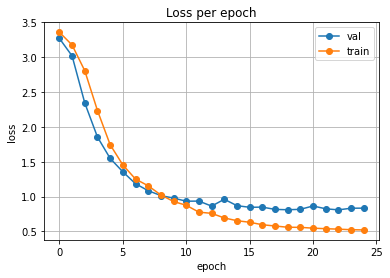

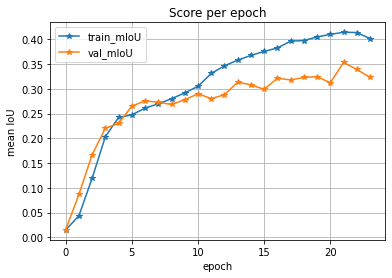

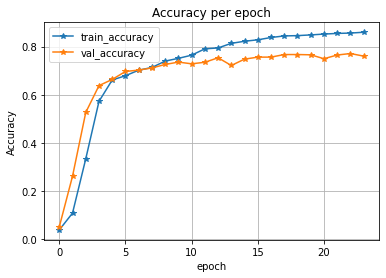

In [32]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Model Validation and Mask Evaluation

## Dataloader class for validation

In [33]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        img = np.asarray(img)
        mask = np.asarray(mask)

        # Define the target size
        target_height = 512
        target_width = 512
        target_width_mask = 512

        target_size = (target_height, target_width)
        target_size_mask = (target_height, target_width_mask)

        # Resize the image
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_LINEAR_EXACT)
        mask = cv2.resize(mask, target_size_mask, interpolation = cv2.INTER_NEAREST_EXACT)

        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


In [34]:
# calling on the validation set for validation test images and masks
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_val, transform=None)

## Loading best model
On the basis of training anf validation losses, loading the model at an optimal epoch

In [62]:
# 21
# loading the best models from the saved folders
model = model.to(device);


if device == 'cuda':
  checkpoint = torch.load('/content/drive/MyDrive/FDL/FDL_project2/model_try10_gpu_deepfvn/model_21.pt')
else:
  checkpoint = torch.load('/content/drive/MyDrive/FDL/FDL_project2/model_try10_gpu_deepfvn/model_21.pt',map_location=torch.device('cpu'))


model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

current_epoch = checkpoint['epoch']

## Defining mask evaluation functions

1. predict_image_mask_miou : compares the ground truth with predicted output labels per class to generate mIou/similarity/Dice-coefficient

2. predict_image_mask_pixel : compares the ground truth with predicted output labels per pixel to generate pixel accuracy

In [63]:
# mean_store = [0.4416, 0.4683, 0.3926]
# std_store = [0.1777, 0.1602, 0.1885]

def predict_image_mask_miou(model, image, mask, mean=[0.4416, 0.4683, 0.3926], std=[0.1777, 0.1602, 0.1885]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)

    model.to(device); image=image.to(device)

    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [64]:
def predict_image_mask_pixel(model, image, mask, mean=[0.4416, 0.4683, 0.3926], std=[0.1777, 0.1602, 0.1885]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)

    model.to(device); image=image.to(device)

    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

## Calling the validation functions

In [65]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [66]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [67]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/31 [00:00<?, ?it/s]

In [68]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [69]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/31 [00:00<?, ?it/s]

## Results by visualizing mask shapes and classes

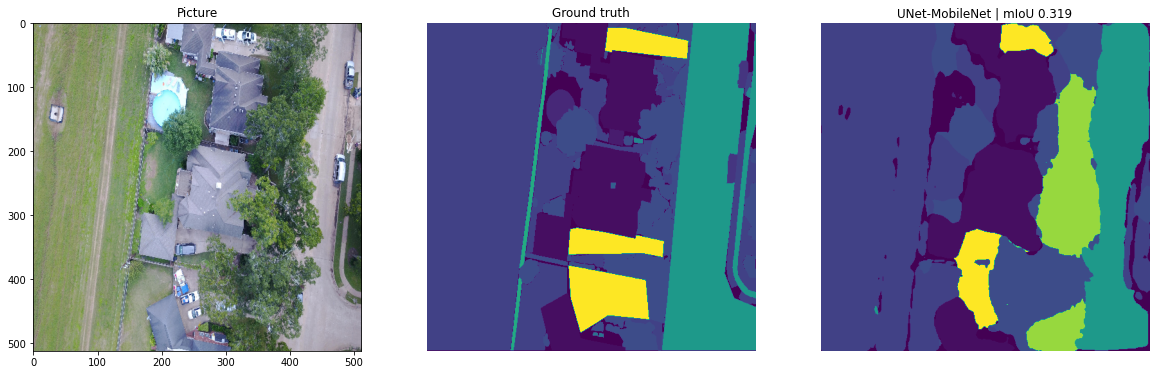

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

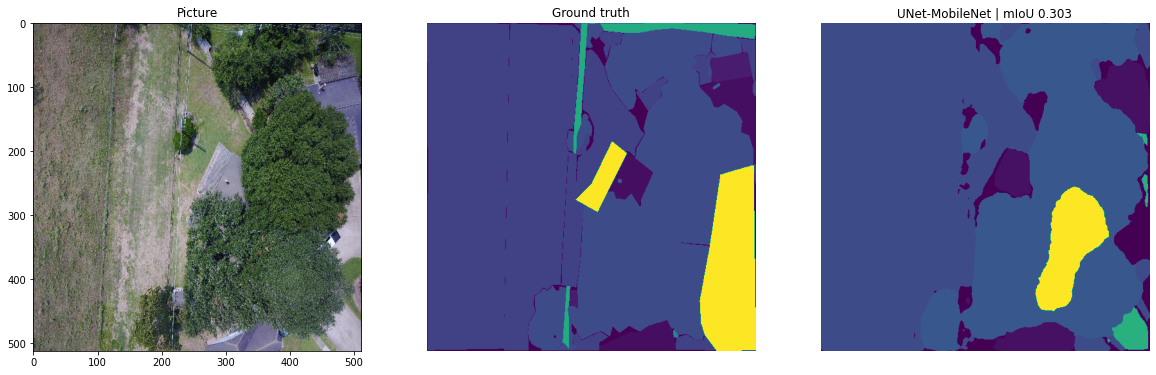

In [71]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

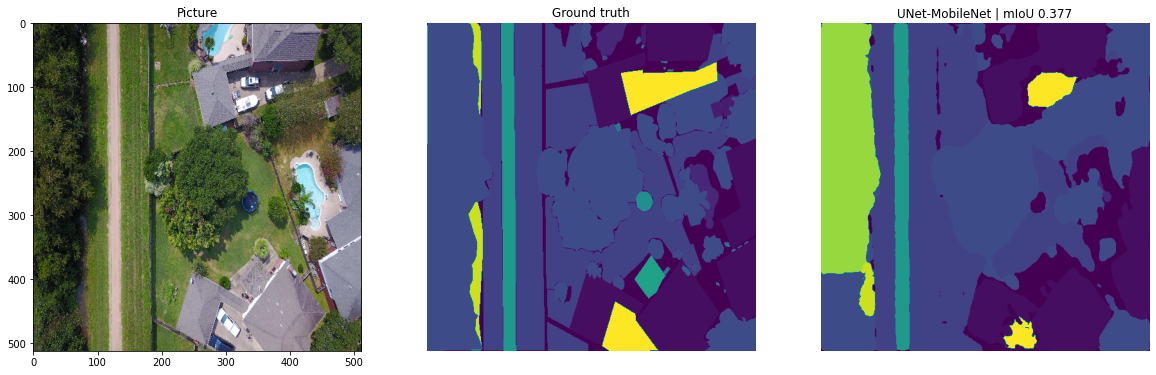

In [72]:
image3, mask3 = test_set[9]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [73]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.3841752415011222


In [74]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7624431733162172


# Output TAR files

In [ ]:
# create mask for test 75 images -> resize as original image - > name it properly

## Dataloader class for test and predictions

In [75]:
class DroneTestFinalDataset(Dataset):
    
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = np.asarray(img)

        # Define the target size
        target_height = 512
        target_width = 512
        
        target_size = (target_height, target_width)

        # Resize the image
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_LINEAR_EXACT)

        
        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        return img


In [76]:
test_df = create_df()[1]['id']

In [77]:
X_test_final = DroneTestFinalDataset(IMAGE_PATH, test_df, transform=None)

In [78]:
# verifying the length of final classes
len(X_test_final)

75

(512, 512, 3)


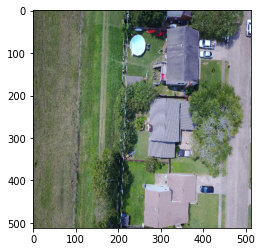

In [79]:
# visualizing a test image
image = X_test_final[8]
plt.imshow(image)
print(np.asarray(image).shape)

## Defining function for predicting final masks

In [80]:
def final_predict_mask(model, image, mean=[0.4416, 0.4683, 0.3926], std=[0.1777, 0.1602, 0.1885]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)

    model.to(device); 
    image=image.to(device)

    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return image, masked

## Visualizing the output mask and resized to original dimensions

6645
(3000, 4000)


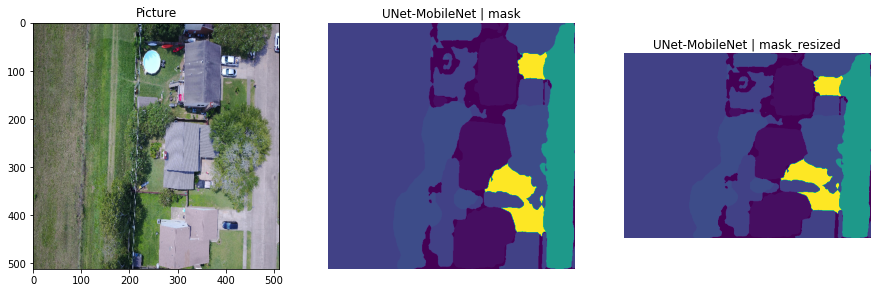

In [81]:
n =8
image = X_test_final[n]
_, pred_mask = final_predict_mask(model, image)

fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(15,12))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(pred_mask)
ax2.set_title('UNet-MobileNet | mask'.format(n))
ax2.set_axis_off()

target_size = (4000,3000)
mask_new = cv2.resize(np.asarray(pred_mask,dtype='uint8'), target_size, interpolation = cv2.INTER_NEAREST_EXACT)

ax3.imshow(mask_new)
ax3.set_title('UNet-MobileNet | mask_resized'.format(n))
ax3.set_axis_off()


print(test_df.iloc[n,])
print(mask_new.shape)

## Uploading files to submission tar

In [82]:
!rm -rf /content/Hurricane_Harvey/new/test_mask_dir

In [83]:
!mkdir -p /content/Hurricane_Harvey/new/test_mask_dir
%cd /content/Hurricane_Harvey/new/test_mask_dir
from google.colab import files

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/content/Hurricane_Harvey/new/test_mask_dir


In [84]:
import os
from PIL import Image

# Create a new folder in Colab
!mkdir /content/Hurricane_Harvey/new/test_mask_dir

mkdir: cannot create directory ‘/content/Hurricane_Harvey/new/test_mask_dir’: File exists


In [85]:
for i in range(test_df.shape[0]):
    img = Image.open(IMAGE_PATH + test_df.iloc[i,] + '.tif')
    image_model = X_test_final[i]

    final_width = np.asarray(img).shape[0]
    final_height = np.asarray(img).shape[1]

    _, pred_mask = final_predict_mask(model, image_model)

    target_size = (final_height,final_width)

    pred_mask_new = cv2.resize(np.asarray(pred_mask,dtype='uint8'), target_size, interpolation = cv2.INTER_NEAREST_EXACT)

    pred_mask_new = Image.fromarray(pred_mask_new).convert('L')
    

    # Save the image as a PNG file
    file_name = test_df.iloc[i,]+".png"
    file_path = "/content/Hurricane_Harvey/new/test_mask_dir/" + file_name
    pred_mask_new.save(file_path)

    print('Image Size:', np.asarray(img).shape, 'Pred Mask Size', np.asarray(pred_mask_new).shape)

Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3072, 4592, 3) Pred Mask Size (3072, 4592)
Image Size: (3072, 4592, 3) Pred Mask Size (3072, 4592)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3072, 4592, 3) Pred Mask Size (3072, 4592)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3072, 4592, 3) Pred Mask Size (3072, 4592)
Image Size: (3072, 4592, 3) Pred Mask Size (3072, 4592)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3072, 4592, 3) Pred Mask Size (3072, 4592)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000, 4000)
Image Size: (3000, 4000, 3) Pred Mask Size (3000

In [86]:
# code for generating a tar zip

import tarfile
num = 13
tar = tarfile.open("submission_"+str(num)+".tar", "w")

for root, dir, files in os.walk('/content/Hurricane_Harvey/new/test_mask_dir'):
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()